TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise



This is the template for the image recognition exercise. <Br>
Some **general instructions**:
 - write a clear *report*, understandable for an unspecialized reader: define shortly the concepts and explain the phases you use
    - use the Markdown feature of the notebook for larger explanations
 - return your output as a working Jupyter notebook
 - name your file as MLPR25_exercise_surname_firstname.jpynb
 - write easily readable code with comments     
     - if you exploit some code from web, provide a reference
     - avoid redundant code! Exploit the relevent parts and modify the code for your purposes to produce only what you need 
 - it is ok to discuss with a friend about the assignment. But it is not ok to copy someone's work. Everyone should submit their own implementation

**Deadline 14th of March at 16:00**
- No extension granted, unless you have an extremely justified reason. In such case, ask for extension well in advance!
- Start now, do not leave it to the last minute. This exercise will need some labour!
- If you encounter problems
    - Google first 
    - ask for help at the discussion area at Moodle
    - email tmvaha@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives 6 points, i.e. the total score is 36 points. Two extra points can be acquired by completing the bonus task. <br>

From the template below, you can see how many exercise points can be acquired from each task. Exam points are given according to the table below: <br>
<br>
9-10 exercise points: 1 point <br>
11-12 exercise points: 2 points <br>
13-14 exercise points: 3 points <br>
15-16 exercise points: 4 points <br>
17-18 exercise points: 5 points <br>
19-20 exercise points: 6 points <br>
<br>
To pass the exercise, you need at least 8 exercise points, distributed somewhat evenly into tasks (you can't just implement Introduction, Data preparation and Feature extraction and leave the left undone!) <br>       

## Introduction

Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?

Three sets of image URLs provided as text files (in Moodle): grass, sand and stairs

Images are with different resolution and dimensions
Images have been gathered from https://unsplash.com/

Purpose of the task is to explore different machine learning classifiers and see how well they could perform on a task where the point is to classify different kind of images (grass, sand and stairs). The images are from unsplash.com and they have different resolutions and dimensions, so they have to be resized so that every image is the same size. 

The images need some preprocessing before training different ML models to classify them. Preprocessing methods that are used contains the resizing of the images like said before, but also grayscaling them and reducing quantization levels of the images. Then as a feature extraction method, RGB statistics and Gray-Level-Co-occurence Matrix (GLCM) are being used. To classify the images, the goal is to train three different ML-models, Ridge Classifier, Random Forest and Multi-Layer Perceptron (MLP), using different hyper parameters. The ML-models are trained and evaluated using Grid Search and Stratified Cross-validation, to see which hyper parameters work best for each model, and which model has the best overall performance.

The code was mainly written with the help of documentation. There was a lot of trial and error, and some web searches where the main source for helpful information was geeksforgeeks.org and stackoverflow.com. 

## Data preparation

Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level, e.g. to 8 levels

In [1]:
# Packages needed for the exercise
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color, feature
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import imageio.v2 as imageio

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def load_images(url_file, save_folder, resize_size=(256, 256), quant_levels=8):
    """Loads images from URLs in a text file, preprocesses them, and saves them."""

    os.makedirs(save_folder, exist_ok=True)
    urls = np.loadtxt(url_file, dtype='U150')  # Load URLs

    images = []
    processed_images = []

    for i, url in enumerate(urls):
        try:
            img = imageio.imread(url)
            img_resized = cv2.resize(img, resize_size) #resize
            img_grayscale = color.rgb2gray(img_resized) #grayscale
            img_quantized = np.round(img_grayscale * (quant_levels - 1)) / (quant_levels - 1) #quantize

            imageio.imwrite(os.path.join(save_folder, f"image_{i}.jpg"), img_resized) #save resized image.

            images.append(img_resized)
            processed_images.append(img_quantized)

        except Exception as e:
            print(f"Error processing {url}: {e}")

    return images, processed_images #return both the color resized images, and the processed grayscale images.

In [3]:
def visualize_images(images, titles):
    """Function that displays a few images to ensure correct preprocessing"""
    fig, axes = plt.subplots(1, len(images), figsize=(15,5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [4]:
# Define file paths and perform preprocessing for the images

categories = ['grass', 'sand', 'stairs']
all_images_resized = {}
all_images = {}

for cat in categories:
    url_file = f"{cat}.txt"
    save_folder = f"images/{cat}"
    resized_images, processed_images = load_images(url_file, save_folder) #load and preprocess
    all_images_resized[cat] = resized_images
    all_images[cat] = processed_images

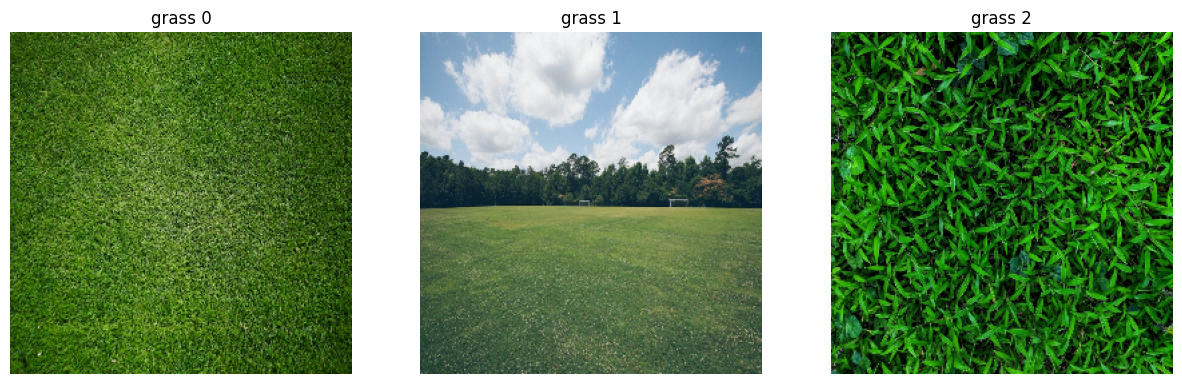

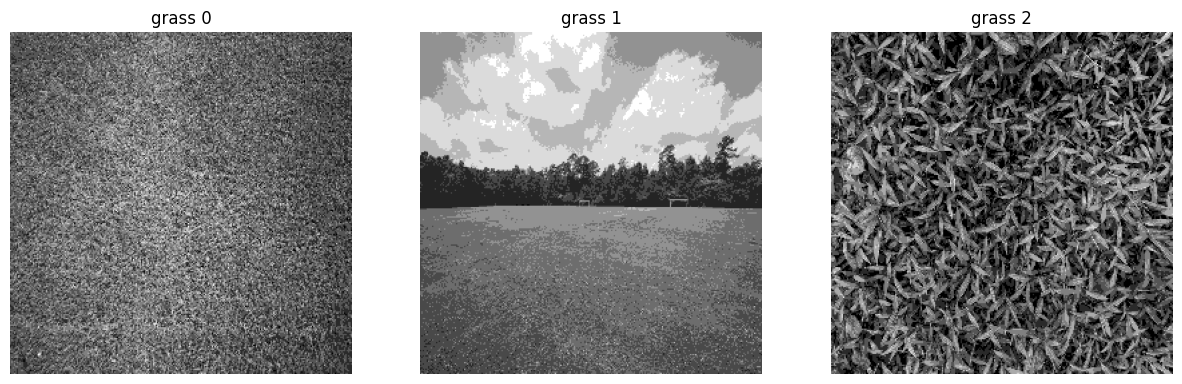

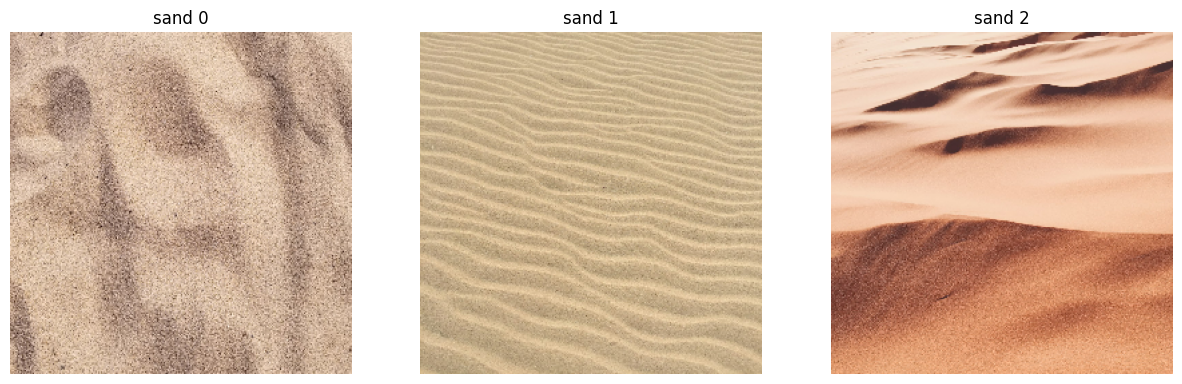

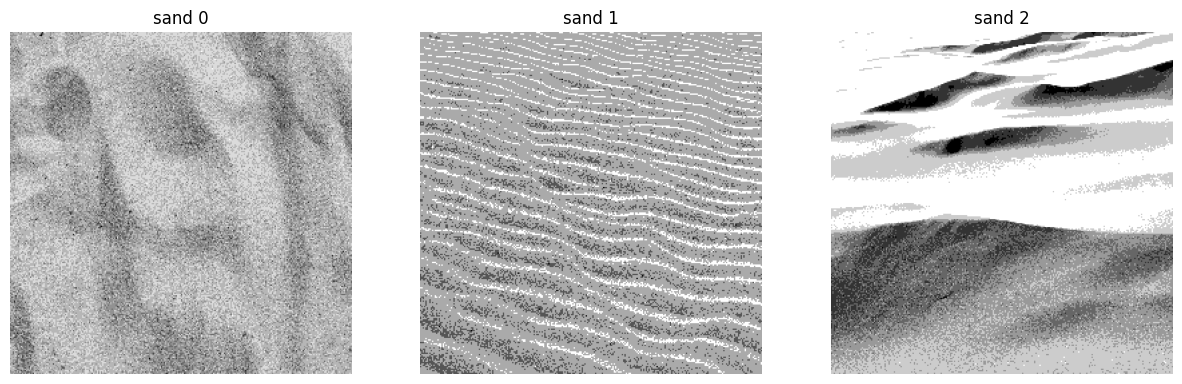

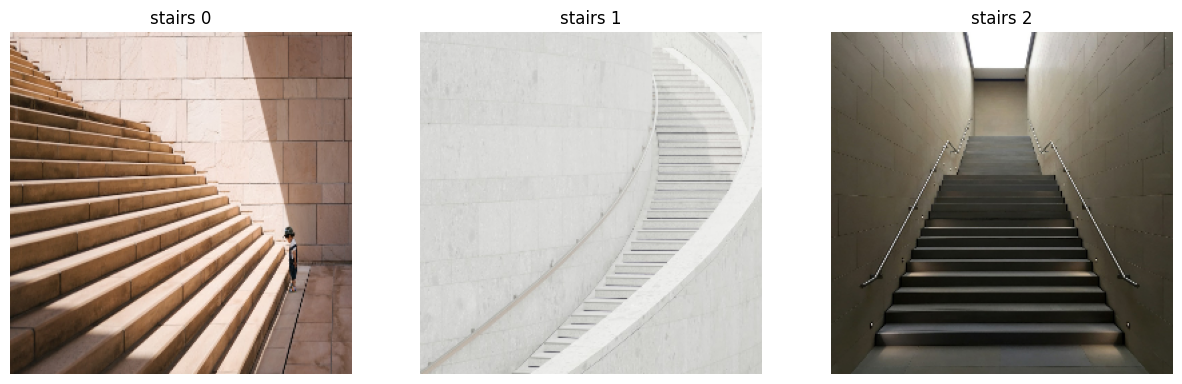

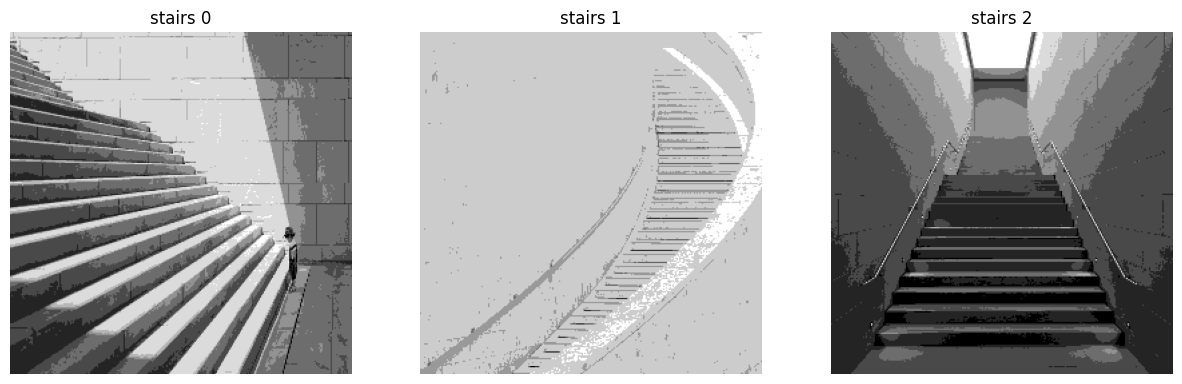

In [5]:
# Visualize a sample of images (showing both resized and fully preprocessed versions)

for cat in categories:
    visualize_images(all_images_resized[cat][:3], [f"{cat} {i}" for i in range(3)])
    visualize_images(all_images[cat][:3], [f"{cat} {i}" for i in range(3)])

## Feature extraction

### First order texture measures (6 features)

- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [6]:
def compute_rgb_stats(images):
    """Function that computes mean and variance for each RGB channel for each image"""
    rgb_stats = []
    for img in images:
        means = np.mean(img, axis=(0, 1))
        variances = np.var(img, axis=(0, 1))
        rgb_stats.append((means, variances))
    return rgb_stats


# Running the function and printing the results
all_rgb_stats = {}

for cat in categories:
    all_rgb_stats[cat] = compute_rgb_stats(all_images_resized[cat]) #using resized color images

for category, stats in all_rgb_stats.items():
    print(f"Category: {category}")
    for i, (means, variances) in enumerate(stats):
        print(f" Image {i}: Mean={means}, Variance={variances}")

Category: grass
 Image 0: Mean=[ 65.17550659 102.69487     26.87080383], Variance=[ 994.60558049 1159.78737358  617.09956506]
 Image 1: Mean=[120.70666504 140.40126038 124.32608032], Variance=[4169.84086499 3309.53480615 5471.86825048]
 Image 2: Mean=[27.3782196  89.64558411 16.60505676], Variance=[ 527.52948106 2890.56083651  419.10535712]
 Image 3: Mean=[101.56672668 118.17645264  22.62190247], Variance=[1080.76364447 1236.52883151  560.88614077]
 Image 4: Mean=[108.63632202 152.2432251   39.01411438], Variance=[2162.49768218 1542.96195971 1488.15273963]
 Image 5: Mean=[ 96.64616394 103.82754517  56.37017822], Variance=[2403.57171471 2434.82630792  723.02748835]
 Image 6: Mean=[ 86.97601318 140.8813324  116.24606323], Variance=[2058.55020588  331.12268253 7559.26940894]
 Image 7: Mean=[125.5919342  116.36338806  34.8469696 ], Variance=[3617.15765528 3560.02088796  922.68204129]
 Image 8: Mean=[76.23397827 93.09941101 33.98083496], Variance=[2032.44049343 2421.11818447  717.04226576]


### Second order texture measures (4 features)

- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - For each image
        - calculate the GLC matrix
        - calculate the "correlation" feature using the GLC matrix that you acquired 
            - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
        - explain your choise for the distances<br>

Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

In [7]:
def compute_glcm_features(images, distances=[1, 3]):
    """Function that calculates the GLC matrix and then calculates the correlation feature"""
    features = []
    glcm = []
    for img in images:
        glcm = feature.graycomatrix((img * 255).astype(np.uint8), distances=distances, angles=[0, np.pi / 2], levels=256, symmetric=True, normed=True)
        corr_matrix = feature.graycoprops(glcm, 'correlation')
        corr_features = corr_matrix.flatten().tolist()
        features.append(corr_features)
    return features

# Perform GLCM correlation feature calculation, store into array X with class labels in array y
all_glcm_features = []
y = []


for cat in categories:
    glcm_features = compute_glcm_features(all_images[cat]) #Using the processed images
    all_glcm_features.extend(glcm_features)
    y.extend([cat] * len(glcm_features))

# Convert into NumPy array, standardize and store in X
X_not_standardized = np.array(all_glcm_features)
scaler = StandardScaler()
X = scaler.fit_transform(X_not_standardized)


In [8]:
print(X)

[[-2.87745775 -2.73971524 -2.39000028 -2.19509225]
 [ 0.63927832  0.63932968  0.84178148  0.88780036]
 [-1.13687065 -0.88091814 -2.35882595 -1.9756754 ]
 [-1.27232485 -0.49008672 -1.46689439 -0.9972423 ]
 [ 0.21528607  0.68875333  0.04083544  0.72021857]
 [-0.46375713  0.40190198 -0.12798951  0.19473963]
 [ 0.34755662  0.11776607  0.53733786  0.05217871]
 [-3.5466807  -3.76185133 -2.96196331 -2.86062334]
 [ 0.11032975  0.67460715 -0.73383463  0.53967069]
 [-0.15419951 -0.20803802  0.0176529  -0.19098505]
 [-1.38619    -0.86267065 -1.05502729 -0.92290862]
 [ 0.70426862  0.49819834  0.86186526  0.59809717]
 [ 0.67770214  0.67513021  0.91659531  0.96509342]
 [-1.61234021 -1.93884148 -1.90601458 -1.94061809]
 [ 0.48145931  0.44901505  0.38158099  0.50207907]
 [ 0.36445966  0.49178231 -0.03970349  0.27130374]
 [-0.16917933  0.76966643 -1.2277425   0.79711124]
 [ 0.03839057  0.12934997  0.06011518 -0.00789755]
 [-0.04731009  0.6715589  -0.40691287  0.65115964]
 [ 0.41325542  0.52341606  0.50

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

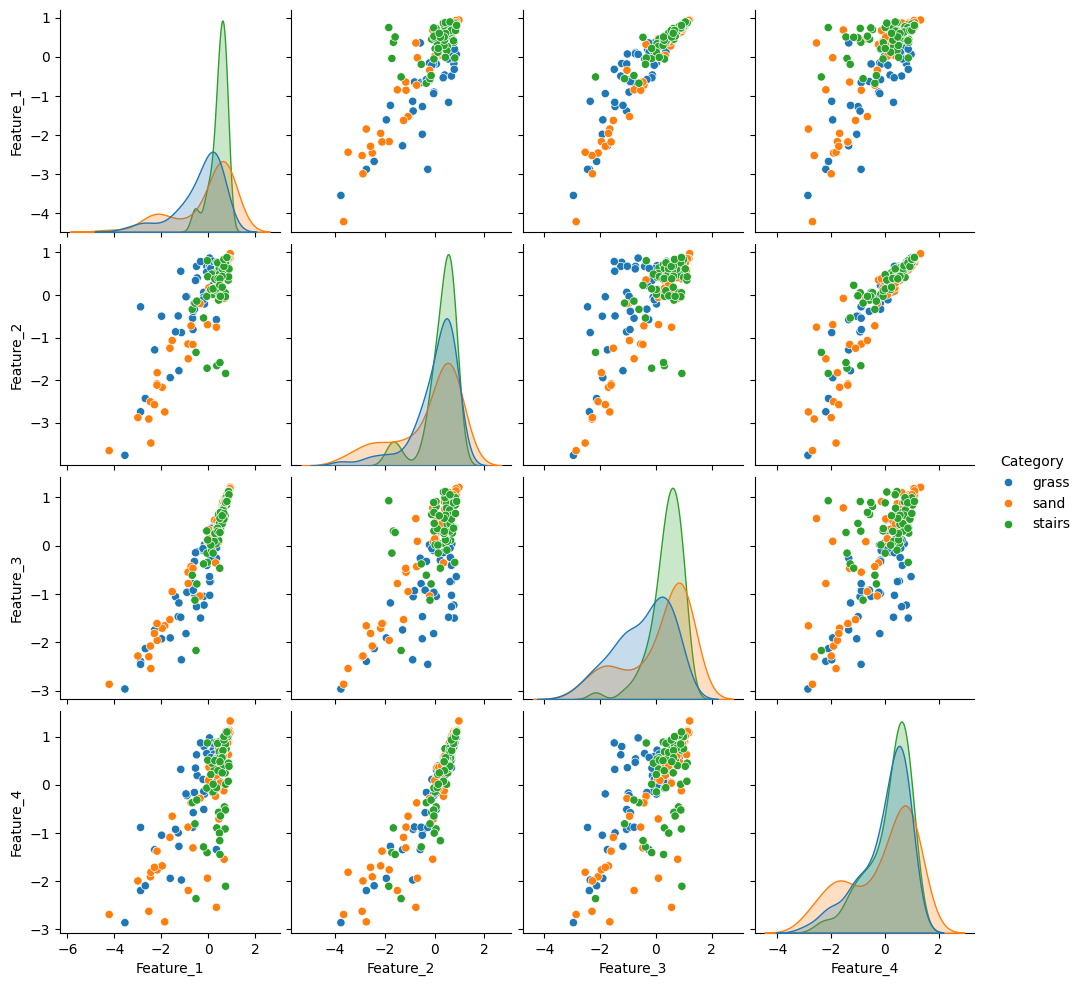

In [9]:
# Convert array into a dataframe and print pairplot
df_X = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(4)])
df_X['Category'] = y
sns.pairplot(df_X, hue='Category')

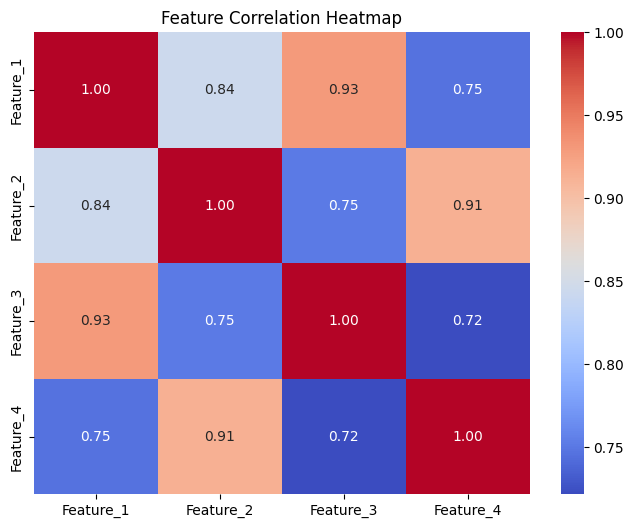

In [10]:
# Print correlation matrix to check linear relationship between each pair
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(4)])

correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") #https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.title("Feature Correlation Heatmap")
plt.show()

From the pairplot and the correlation matrix it's evident that feature pairs (1, 3) and (2, 4) have the clearest linear relationships. There is a certain level of correlation between every feature pair, which suggests that they all will have an impact when performing the classification.

### Histograms

- Histograms **(1 p)**
    - Plot a histogram for each Z-scored feature. Plot all the image classes in the same figure and use different color for each.
    - Which features may have some discriminative power over image classes according to the histograms? <br>

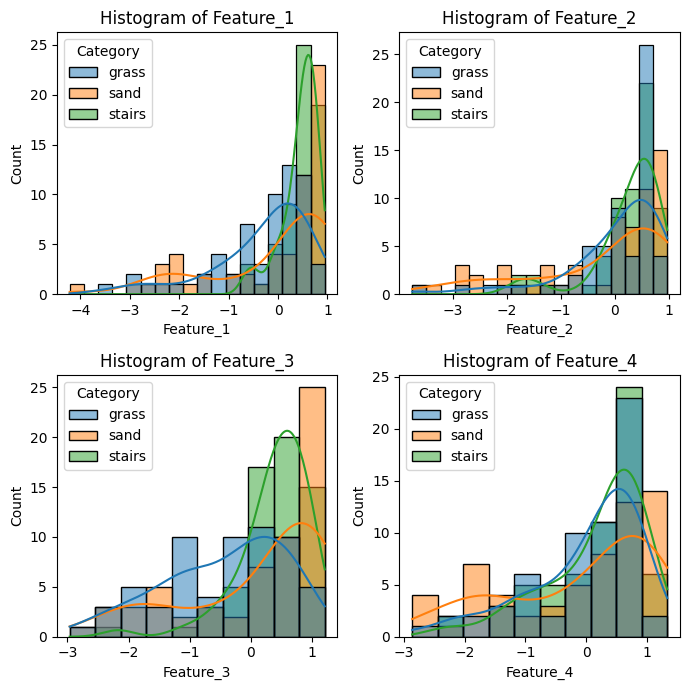

In [11]:
# Standardized features into a DataFrame for plotting
df_features = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
df_features['Category'] = y

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()

for i, feature in enumerate(df_features.columns[:-1]):  # Exclude last column (Category column)
    sns.histplot(data=df_features, x=feature, hue='Category', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

In histograms for features 1 and 3, there is a clear spike for category stairs, which would mean that those features have discriminative power over the other two image classes. Other than that, the distribution of values is pretty similar for all image classes. The histograms further validate previously made statement that every feature will have some importance, but features 1 and 3 possess the most discriminative power.

### PCA

- PCA **(1 p)**
    - Plot the image glasses using different colors.
    - Can you see clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.

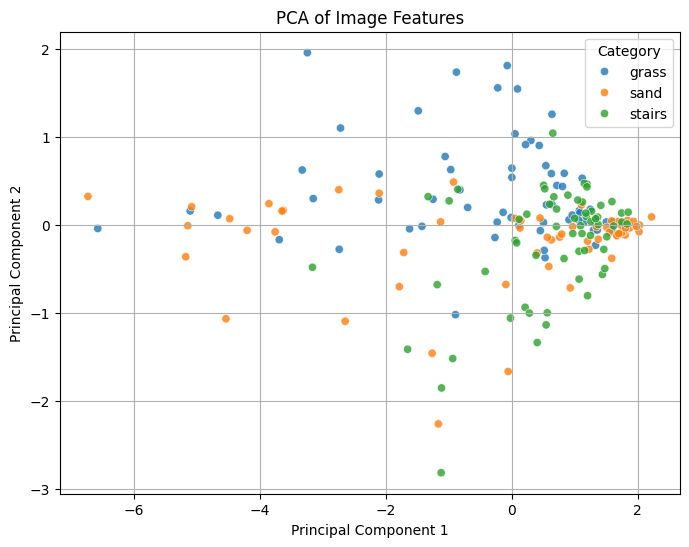

In [12]:
# Perform PCA with two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Convert to DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Category'] = y

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Category', palette='tab10', alpha=0.8)
plt.title('PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category')
plt.grid(True)
plt.show()

There isn't really any clear clusters, but the grass class is more spread out with lower PC2 values while sand class is more in the middle and stairs class has more values with PC2 value under 0. PC1 values are very much concentrated around value 2, with some separation especially with grass and sand images. Based on the PCA it might be hard for something like ridge classifier to classify the images correctly, but a more robust model like MLP might do better.

## Build classifiers and select the best hyperparameters with cross validation

Perform model selection for each classifier. Use 5-fold stratified cross validation (*StratifiedKFold* and *GridSearchCV* from sklearn). Use the following hyperparameters:

- Ridge Classifier (1 p)
    - strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

- Random Forest **(1 p)**
    - n_estimators from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not 
    
- MLP **(1 p)**
    - use one hidden layer
    - number of neurons in the hidden layer from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier:
- Report the selected combination of hyperparameters <br>
- Report the accuracy value for each hyperparameter combination <br>

For Random Forest model, report the feature importance for each feature. Which features seem to be the most important? Does this correspond with the observations you made in the data exploration? **(1 p)**

In [13]:
# Ridge classifier
# Hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
ridge = RidgeClassifier()

# Perform grid search
grid_search = GridSearchCV(ridge, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

# Print accuracy for each combination and the best score
print("Best parameter:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

for alpha, mean_score in zip(param_grid['alpha'], grid_search.cv_results_['mean_test_score']):
    print(f"Alpha {alpha}: {mean_score:.8f}")

Best parameter: {'alpha': 0.001}
Best accuracy: 0.5945945945945946
Alpha 0.001: 0.59459459
Alpha 0.01: 0.59459459
Alpha 0.1: 0.59459459
Alpha 1.0: 0.56756757


In [14]:
# Random Forest
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Print accuracy for each combination and the best score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.6f}")

# Train best model and get feature importances
best_rf = grid_search.best_estimator_
feature_importances = best_rf.feature_importances_

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}
Best accuracy: 0.5567567567567567
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}: 0.540541
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150}: 0.540541
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200}: 0.535135
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 250}: 0.524324
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300}: 0.524324
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}: 0.540541
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 150}: 0.540541
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 200}: 0.535135
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 250}: 0.524324
{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 300}: 0.524324
{'bootstrap': True, 'max_features': None, 'n_estimators': 100}: 0.556757
{

In [15]:
# MLP
# Hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(n,) for n in range(15, 45, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.1, 1],
    'validation_fraction': [0.1, 0.3],
}

# Initialize the model
mlp = MLPClassifier(max_iter=5000, random_state=42)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Print accuracy for each combination and the best score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.6f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1}
Best accuracy: 0.6324324324324324
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'sgd', 'validation_fraction': 0.1}: 0.491892
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'sgd', 'validation_fraction': 0.3}: 0.491892
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1}: 0.589189
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.3}: 0.589189
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'sgd', 'validation_fraction': 0.1}: 0.464865
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'sgd', 'validation_fraction': 0.3}: 0.464865
{'activation': 'tanh', 'alpha': 0.01, '

### Analyzing the results ###
**Ridge Classifier**

Best parameter: {'alpha': 0.001}

Best accuracy: 0.5945945945945946

Best results were attained by using regularization term alpha = 0.001, but same results were attained also if alpha was 0.1 or 0.01. Accuracy value 0.5946 means that the model was able to classify almost 60% of the images correctly.

**Random Forest**

Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}

Best accuracy: 0.5567567567567567

feature_1: 0.2596

feature_2: 0.2510

feature_3: 0.2960

feature_4: 0.1934

Random Forest was able to get an accuracy score of 0.5568 with the parameter values {'bootstrap': True, 'max_features': None, 'n_estimators': 100}. From feature importance values feature_3 had the highest score of 0.296, with feature_1 and feature_2 being pretty close to each other with scores 0.2596 and 0.2510 respectively. These feature importances align with the observations made in data exploration with histograms. All features are pretty close to each other, but there is still a clear difference between them.

**MLP** 

Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1}

Best accuracy: 0.6324324324324324

MLP was able to classify 63.24% of the images correctly with parameter values of {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1}. This accuracy score is clearly the highest and corresponds to previously made statement that the task might need a more robust model to get better scores, since the features are pretty similar to each other.

## Estimate the performance of the models with nested cross-validation

Estimate the performance of each model using nested cross validation. <br>
We'll use 4-fold Stratified Kfold cross-validation and the same parameter ranges as earlier for the inner loop. <br>
For the outer loop we'll use 5-fold Stratified Kfold cross-validation.

For each classifier: 
- Ridge Classifier **(1 p)**
- Random Forest **(1 p)**
- MLP **(1 p)**

    Report the selected combination of the hyperparameters and the accuracy value for the best hyperparameter combination. <br> 
    Create a confusion matrix of the results. <br>
    Calculate the mean accuracy of the outer rounds. What does it mean? **(1 p)**

In [16]:
# Ridge classifier
# Hyperparameter grid
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1.0]}

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ridge_accuracies = []
all_conf_matrices = []

y = np.array(y)

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner CV 
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    ridge = RidgeClassifier()
    grid_search = GridSearchCV(ridge, param_grid_ridge, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate best model on outer fold
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store accuracy
    acc = accuracy_score(y_test, y_pred)
    ridge_accuracies.append(acc)

    # Store confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    all_conf_matrices.append(conf_matrix)

    print(f"Best parameters: {grid_search.best_params_}, Accuracy: {acc:.4f}")

# Mean accuracy
mean_accuracy_ridge = sum(ridge_accuracies) / len(ridge_accuracies)
print(f"Mean Accuracy (Ridge Classifier): {mean_accuracy_ridge:.4f}")


Best parameters: {'alpha': 0.001}, Accuracy: 0.5946
Best parameters: {'alpha': 0.001}, Accuracy: 0.7297
Best parameters: {'alpha': 0.001}, Accuracy: 0.5405
Best parameters: {'alpha': 1.0}, Accuracy: 0.5676
Best parameters: {'alpha': 0.1}, Accuracy: 0.4595
Mean Accuracy (Ridge Classifier): 0.5784


In [17]:
# Random Forest
# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_accuracies = []
all_conf_matrices_rf = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner CV 
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid_rf, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate best model on outer fold
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store accuracy
    acc = accuracy_score(y_test, y_pred)
    rf_accuracies.append(acc)

    # Store confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    all_conf_matrices_rf.append(conf_matrix)

    print(f"Best parameters: {grid_search.best_params_}, Accuracy: {acc:.4f}")

# Mean accuracy
mean_accuracy_rf = sum(rf_accuracies) / len(rf_accuracies)
print(f"Mean Accuracy (Random Forest): {mean_accuracy_rf:.4f}")

Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}, Accuracy: 0.5405
Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 250}, Accuracy: 0.4865
Best parameters: {'bootstrap': False, 'max_features': None, 'n_estimators': 100}, Accuracy: 0.4865
Best parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}, Accuracy: 0.5676
Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 150}, Accuracy: 0.5676
Mean Accuracy (Random Forest): 0.5297


In [18]:
# MLP
# Hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(n,) for n in range(15, 45, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.1, 1],
    'validation_fraction': [0.1, 0.3]
}

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_accuracies = []
all_conf_matrices_mlp = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner CV 
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    mlp = MLPClassifier(max_iter=5000, random_state=42)
    grid_search = GridSearchCV(mlp, param_grid_mlp, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluate best model on outer fold
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Store accuracy
    acc = accuracy_score(y_test, y_pred)
    mlp_accuracies.append(acc)

    # Store confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    all_conf_matrices_mlp.append(conf_matrix)

    print(f"Best parameters: {grid_search.best_params_}, Accuracy: {acc:.4f}")

# Mean accuracy
mean_accuracy_mlp = sum(mlp_accuracies) / len(mlp_accuracies)
print(f"Mean Accuracy (MLP): {mean_accuracy_mlp:.4f}")


Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5405
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5135
Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5946
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5946
Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.4865
Mean Accuracy (MLP): 0.5459


[[35 19  8]
 [ 4 28 29]
 [14  4 44]]


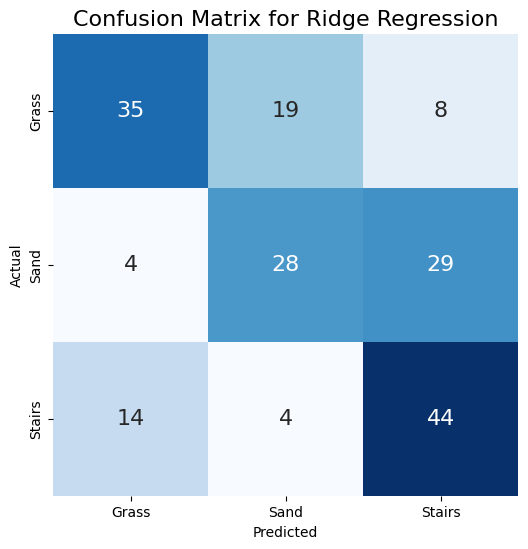

[[31 16 15]
 [13 34 14]
 [17 12 33]]


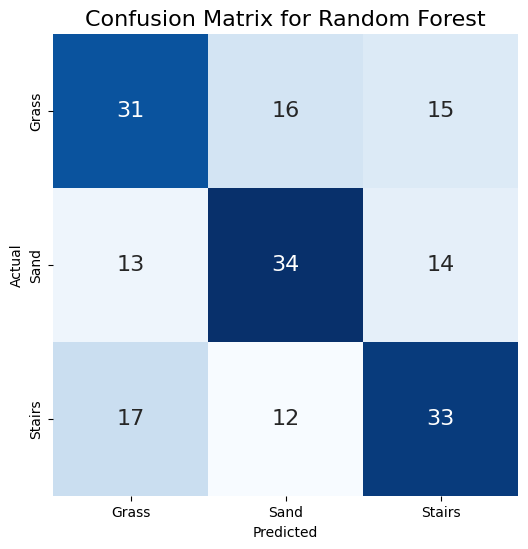

[[30 15 17]
 [12 37 12]
 [14 14 34]]


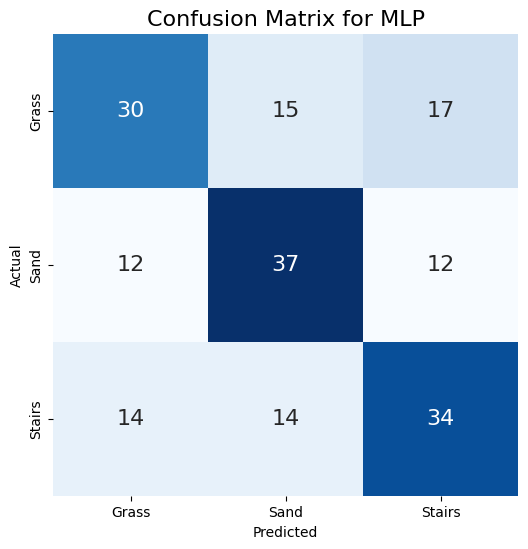

In [19]:
def plot_confusion_matrices(conf_matrices, model_name):
    # Sum up confusion matrices from different cross validation folds
    summed_matrix = np.sum(conf_matrices, axis=0)
    print(summed_matrix)
    # Plot the summed matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(summed_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Grass', 'Sand', 'Stairs'], yticklabels=['Grass', 'Sand', 'Stairs'],
                annot_kws={"size": 16})
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(all_conf_matrices, "Ridge Regression")
plot_confusion_matrices(all_conf_matrices_rf, "Random Forest")
plot_confusion_matrices(all_conf_matrices_mlp, "MLP")


From the confusion matrices it can be seen that even though the ridge classifier has the best overall performance, it has hard time classifying the sand images, often confusing them to be stairs. This might also be a reason why it has so high true positive rate for classifying stairs correctly and increasing its overall accuracy value to be higher than other classifiers. Based on the confusion matrices, MLP might actually be the best of the three, since it has higher accuracy than random forest, and the true positive rate is more evenly distributed across different image classes, making it more consistent.

### Analyzing the results ###
**Ridge Classifier**

Best parameters: {'alpha': 0.001}, Accuracy: 0.5946

Best parameters: {'alpha': 0.001}, Accuracy: 0.7297

Best parameters: {'alpha': 0.001}, Accuracy: 0.5405

Best parameters: {'alpha': 1.0}, Accuracy: 0.5676

Best parameters: {'alpha': 0.1}, Accuracy: 0.4595

Mean Accuracy (Ridge Classifier): 0.5784

Mean accuracy of the outer rounds for ridge regression was 0.5784. It is slightly better than what was achieved before in the model selection part, considerably better than what random selection would be (0.33)

**Random Forest**

Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 100}, Accuracy: 0.5405

Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 250}, Accuracy: 0.4865

Best parameters: {'bootstrap': False, 'max_features': None, 'n_estimators': 100}, Accuracy: 0.4865

Best parameters: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}, Accuracy: 0.5676

Best parameters: {'bootstrap': True, 'max_features': None, 'n_estimators': 150}, Accuracy: 0.5676

Mean Accuracy (Random Forest): 0.5297

Mean accuracy for Random Forest was 0.5297. It's a little bit worse than before in the model selection, but it is more likely to be closer to the models true performance on unseen data, because of the nested cross validation.


**MLP** 

Best parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (15,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5405

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5135

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5946

Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (40,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.5946

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (20,), 'solver': 'adam', 'validation_fraction': 0.1}, Accuracy: 0.4865

Mean Accuracy (MLP): 0.5459

Mean accuracy for MLP was 0.5459. There is a significant drop in accuracy compared to before, but again it's a more realistic estimate of the models performance.

## Discussion

- Discuss you results **(2 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?

The Ridge Classifier performs the best with a mean accuracy of 0.5784. This is a little bit surprising after the data exploration and model selection. This suggests that linear relationships captured by Ridge Regression are still effective, possibly because the GLCM features have captured some of the data's linear separability.

All models have relatively low mean accuracies, indicating limitations in the discriminative power of the features or potential class overlap. The models struggle to consistently classify across different data splits, as shown by the variance in accuracy between the outer folds.

Results could be improved by using different features, such as contrast, dissimilarity and homogeneity. Also using more complex models and exploring wider range of hyper parameters could improve the results to better capture the differences between different classes.